# Figure 2f
This notebook reproduces the GP regression plots provided in Figure 2. The code is kind of verbose, but I wanted to be sort of explicit about what I'm doing to generate these figures.

In [1]:
import torch
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import GP regression code
from importlib import reload
import dli_gpr

%matplotlib inline

# Input data
Read input text files (provided in data directory of this repository).

In [6]:
data_dir = "data"

# data files
pe1_r_fname = os.path.join(data_dir, "v3_MetaclusterPE1_R_gprinput.txt")
pe1_nr_fname = os.path.join(data_dir, "v3_MetaclusterPE1_NR_gprinput.txt")
pe2_r_fname = os.path.join(data_dir, "v3_MetaclusterPE2_R_gprinput.txt")
pe2_nr_fname = os.path.join(data_dir, "v3_MetaclusterPE2_NR_gprinput.txt")
te_r_fname = os.path.join(data_dir, "v3_MetaclusterTE_R_gprinput.txt")
te_nr_fname = os.path.join(data_dir, "v3_MetaclusterTE_NR_gprinput.txt")

# read these with pandas (tsv)
pe1_r_df = pd.read_csv(pe1_r_fname, sep="\t")
pe1_nr_df = pd.read_csv(pe1_nr_fname, sep="\t")
pe2_r_df = pd.read_csv(pe2_r_fname, sep="\t")
pe2_nr_df = pd.read_csv(pe2_nr_fname, sep="\t")
te_r_df = pd.read_csv(te_r_fname, sep="\t")
te_nr_df = pd.read_csv(te_nr_fname, sep="\t")

# get rid of NaNs
pe1_r_df.dropna(inplace=True)
pe1_nr_df.dropna(inplace=True)
pe2_r_df.dropna(inplace=True)
pe2_nr_df.dropna(inplace=True)
te_r_df.dropna(inplace=True)
te_nr_df.dropna(inplace=True)

In [7]:
# check to make sure looks ok
pe1_r_df

,time,proportion(y),numcellsincluster(x),totalcellsinsample(n),patientID,sampleID,tumorburden
0,-30,0.0000,1,329,DFCI-5310,1,94.0
1,180,0.2031,21,1310,DFCI-5310,2,0.0
2,-42,0.0000,127,2834,DFCI-5309,5,11.0
3,90,0.0005,88,2030,DFCI-5309,6,0.0
4,0,0.0437,7,3184,DFCI-5311,9,44.0
6,90,0.0125,32,3762,DFCI-5311,11,0.0
7,270,0.0926,24,8662,DFCI-5311,12,0.0
8,0,0.0022,116,1358,DFCI-5312,21,38.0
9,270,0.0769,1,13,DFCI-5312,22,0.0
10,-5,0.0264,10,1174,DFCI-5317,23,80.0


# Prepare GPR input for tumor burden
This is a regular GPR model. We use the same bandwidth for all models, use SE of the data to initialize the variance.

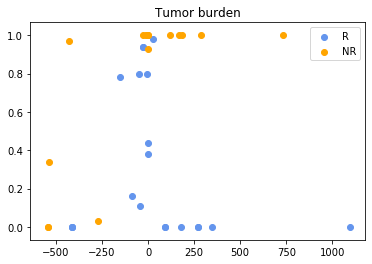

In [46]:
# time input
time_r = pe2_r_df["time"].values
tb_r = pe2_r_df["tumorburden"].values/100.
time_nr = pe2_nr_df["time"].values
tb_nr = pe2_nr_df["tumorburden"].values/100.

# plot stuff to make sure it looks ok
plt.scatter(time_r, tb_r, c="cornflowerblue", label="R")
plt.scatter(time_nr, tb_nr, c="orange", label="NR")
plt.title("Tumor burden")
plt.legend()

In [127]:
reload(dli_gpr)
# convert everything to torch tensors
torch_time_r = torch.FloatTensor(time_r)
torch_time_nr = torch.FloatTensor(time_nr)
torch_tb_r = torch.FloatTensor(tb_r)
torch_tb_nr = torch.FloatTensor(tb_nr)

# initialize models
tb_r_model = dli_gpr.gpr(torch_time_r, torch_tb_r)
tb_nr_model = dli_gpr.gpr(torch_time_nr, torch_tb_nr)

# have to initialize kernel
tb_r_model.initialize_variables()
tb_nr_model.initialize_variables()

In [128]:
# optimize sigma by max likelihood
pyro.clear_param_store()
tb_r_losses = tb_r_model.optimize(n_steps=5000)

pyro.clear_param_store()
tb_nr_losses = tb_nr_model.optimize(n_steps=5000)

100%|██████████| 5000/5000 [00:05<00:00, 986.92it/s] 


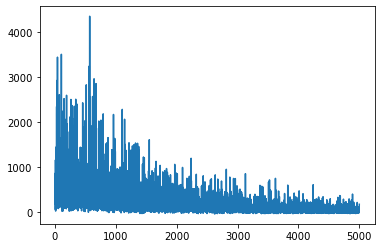

In [129]:
# make sure looks like it is actually converging
plt.plot(tb_nr_losses)

In [130]:
# get predictions for new points...
# new input time points
new_y = torch.FloatTensor(np.linspace(-600, 1200, 100))

# compute conditional distribution of response variable
tb_r_mean, tb_r_cov = tb_r_model.conditional_distribution(new_y)
tb_nr_mean, tb_nr_cov = tb_nr_model.conditional_distribution(new_y)

In [131]:
# prepare values for plotting

# time points as numpy array
new_times = new_y.numpy()

# means
tb_r_mean = tb_r_mean.numpy()
tb_nr_mean = tb_nr_mean.numpy()

# variance
tb_r_var = torch.diag(tb_r_cov).numpy()
tb_nr_var = torch.diag(tb_nr_cov).numpy()

Text(0.5, 1.0, 'Tumor burden\nNR')

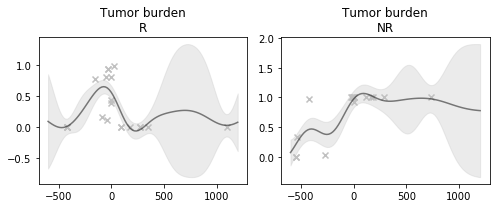

In [132]:
# make plots
fig, ax = plt.subplots(1,2, figsize=(7,3), tight_layout=True)

# plot tumor burden for R
ax[0].plot(new_times, tb_r_mean, "k-", alpha=0.5)
ax[0].scatter(time_r, tb_r, c="silver", marker="x")
ax[0].fill_between(new_times, tb_r_mean + tb_r_var, tb_r_mean - tb_r_var, color="silver", alpha=0.3)
ax[0].set_title("Tumor burden\nR")

# plot tumor burden for NR
ax[1].plot(new_times, tb_nr_mean, "k-", alpha=0.5)
ax[1].scatter(time_nr, tb_nr, c="silver", marker="x")
ax[1].fill_between(new_times, tb_nr_mean + tb_nr_var, tb_nr_mean - tb_nr_var, color="silver", alpha=0.3)
ax[1].set_title("Tumor burden\nNR")

# Metacluster models
This is the hierarchical model for heteroskedascic noise.

In [217]:
# prepare input (numpy arrays)
te_r = te_r_df["proportion(y)"].values
pe1_r = pe1_r_df["proportion(y)"].values
pe2_r = pe2_r_df["proportion(y)"].values
te_nr = te_nr_df["proportion(y)"].values
pe1_nr = pe1_nr_df["proportion(y)"].values
pe2_nr = pe2_nr_df["proportion(y)"].values

# convert to torch tensors
torch_te_r = torch.FloatTensor(te_r)
torch_pe1_r = torch.FloatTensor(pe1_r)
torch_pe2_r = torch.FloatTensor(pe2_r)
torch_te_nr = torch.FloatTensor(te_nr)
torch_pe1_nr = torch.FloatTensor(pe1_nr)
torch_pe2_nr = torch.FloatTensor(pe2_nr)

In [218]:
# get relative weights for each
sizes_r = te_r_df["totalcellsinsample(n)"].values
sizes_nr = te_nr_df["totalcellsinsample(n)"].values

# convert to torch
torch_sizes_r = torch.FloatTensor(sizes_r)
torch_sizes_nr = torch.FloatTensor(sizes_nr)

In [219]:
# initialize models
reload(dli_gpr)
te_r_model = dli_gpr.dli_gpr(torch_time_r, torch_te_r, torch_sizes_r)
pe1_r_model = dli_gpr.dli_gpr(torch_time_r, torch_pe1_r, torch_sizes_r)
pe2_r_model = dli_gpr.dli_gpr(torch_time_r, torch_pe2_r, torch_sizes_r)
te_nr_model = dli_gpr.dli_gpr(torch_time_nr, torch_te_nr, torch_sizes_nr)
pe1_nr_model = dli_gpr.dli_gpr(torch_time_nr, torch_pe1_nr, torch_sizes_nr)
pe2_nr_model = dli_gpr.dli_gpr(torch_time_nr, torch_pe2_nr, torch_sizes_nr)

# initialize variables
te_r_model.initialize_variables()
pe1_r_model.initialize_variables()
pe2_r_model.initialize_variables()
te_nr_model.initialize_variables()
pe1_nr_model.initialize_variables()
pe2_nr_model.initialize_variables()

In [ ]:
for model in [te_r_model, pe1_r_model, pe2_r_model, te_nr_model, pe1_nr_model, pe2_nr_model]:
    pyro.clear_param_store()
    model.optimize(n_steps=5000)

 84%|████████▎ | 4185/5000 [00:07<00:01, 559.95it/s]

In [ ]:
# compute conditional distribution of response variable
te_r_mean, te_r_cov = te_r_model.conditional_distribution(new_y)
pe1_r_mean, pe1_r_cov = pe1_r_model.conditional_distribution(new_y)
pe2_r_mean, pe2_r_cov = pe2_r_model.conditional_distribution(new_y)

te_nr_mean, te_nr_cov = te_nr_model.conditional_distribution(new_y)
pe1_nr_mean, pe1_nr_cov = pe1_nr_model.conditional_distribution(new_y)
pe2_nr_mean, pe2_nr_cov = pe2_nr_model.conditional_distribution(new_y)

In [ ]:
# convert back to numpy array for plotting
te_r_mean, te_r_var = te_r_mean.numpy(), np.diag(te_r_cov.numpy())
pe1_r_mean, pe1_r_var = pe1_r_mean.numpy(), np.diag(pe1_r_cov.numpy())
pe2_r_mean, pe2_r_var = pe2_r_mean.numpy(), np.diag(pe2_r_cov.numpy())

te_nr_mean, te_nr_var = te_nr_mean.numpy(), np.diag(te_nr_cov.numpy())
pe1_nr_mean, pe1_nr_var = pe1_nr_mean.numpy(), np.diag(pe1_nr_cov.numpy())
pe2_nr_mean, pe2_nr_var = pe2_nr_mean.numpy(), np.diag(pe2_nr_cov.numpy())

In [ ]:
# get metacell cluster sizes for plotting
plotting_sizes_r = sizes_r/50
plotting_sizes_nr = sizes_nr/50

In [ ]:
# make plots
fig, ax = plt.subplots(2,3, figsize=(12,5), tight_layout=True)

# plot metacluster TE for R
ax[0,0].plot(new_times, te_r_mean, "cornflowerblue", alpha=0.5)
ax[0,0].scatter(time_r, te_r, c="cornflowerblue", marker=".", sizes=plotting_sizes_r)
ax[0,0].fill_between(new_times, te_r_mean + te_r_var, te_r_mean - te_r_var, color="cornflowerblue", alpha=0.3)
ax[0,0].set_title("TE R")

# plot metacluster TE for NR
ax[1,0].plot(new_times, te_nr_mean, c="orange", alpha=0.5)
ax[1,0].scatter(time_nr, te_nr, c="orange", marker=".", sizes=plotting_sizes_nr)
ax[1,0].fill_between(new_times, te_nr_mean + te_nr_var, te_nr_mean - te_nr_var, color="orange", alpha=0.3)
ax[1,0].set_title("TE NR")

# plot metacluster PE1 for R
ax[0,1].plot(new_times, pe1_r_mean, "cornflowerblue", alpha=0.5)
ax[0,1].scatter(time_r, pe1_r, c="cornflowerblue", marker=".", sizes=plotting_sizes_r)
ax[0,1].fill_between(new_times, pe1_r_mean + pe1_r_var, pe1_r_mean - pe1_r_var, color="cornflowerblue", alpha=0.3)
ax[0,1].set_title("PE R")

# plot metacluster PE1 for NR
ax[1,1].plot(new_times, pe1_nr_mean, "orange", alpha=0.5)
ax[1,1].scatter(time_nr, pe1_nr, c="orange", marker=".", sizes=plotting_sizes_nr)
ax[1,1].fill_between(new_times, pe1_nr_mean + pe1_nr_var, pe1_nr_mean - pe1_nr_var, color="orange", alpha=0.3)
ax[1,1].set_title("PE2 NR")

# plot metacluster PE1 for R
ax[0,2].plot(new_times, pe2_r_mean, "cornflowerblue", alpha=0.5)
ax[0,2].scatter(time_r, pe2_r, c="cornflowerblue", marker=".", sizes=plotting_sizes_r)
ax[0,2].fill_between(new_times, pe2_r_mean + pe2_r_var, pe2_r_mean - pe2_r_var, color="cornflowerblue", alpha=0.3)
ax[0,2].set_title("PE R")

# plot metacluster PE1 for NR
ax[1,2].plot(new_times, pe2_nr_mean, "orange", alpha=0.5)
ax[1,2].scatter(time_nr, pe2_nr, c="orange", marker=".", sizes=plotting_sizes_nr)
ax[1,2].fill_between(new_times, pe2_nr_mean + pe2_nr_var, pe2_nr_mean - pe2_nr_var, color="orange", alpha=0.3)
ax[1,2].set_title("PE2 NR")

# add duplicated axis to plot tumor burden for R
for ix in range(3):
    ax2 = ax[0,ix].twinx()
    ax2.plot(new_times, tb_r_mean, "k-", alpha=0.5)
    ax2.scatter(time_r, tb_r, c="k", marker="x", alpha=0.5)
    ax2.fill_between(new_times, tb_r_mean + tb_r_var, tb_r_mean - tb_r_var, color="silver", alpha=0.3)
    # limit y axis
    ax[0,ix].set_ylim(-0.2, 0.8)
    ax2.set_ylim(-0.2,1.2)
    if ix==2:
        ax2.set_ylabel("tumor burden\nR")
    if ix==0:
        ax[0,ix].set_ylabel("metacluster\nproportion")
        
# add duplicated axis to plot tumor burden for NR
for ix in range(3):
    ax2 = ax[1,ix].twinx()
    ax2.plot(new_times, tb_nr_mean, "k-", alpha=0.5)
    ax2.scatter(time_nr, tb_nr, c="k", marker="x", alpha=0.5)
    ax2.fill_between(new_times, tb_nr_mean + tb_nr_var, tb_nr_mean - tb_nr_var, color="silver", alpha=0.3)
    # limit y axis
    ax[1,ix].set_ylim(-0.2, 0.8)
    ax2.set_ylim(-0.2,1.2)
    if ix==2:
        ax2.set_ylabel("tumor burden\nR")
    if ix==0:
        ax[1,ix].set_ylabel("metacluster\nproportion")
        
# save figure
# plt.savefig("figure2.pdf")

# Cross correlation analysis
The simplest thing to do is to a Gaussian process model to tumor burdens under different shifts, then compute the correlation between the estimated mean tumor burden and metacluster proportions. This is done separately for each cluster below.

In [181]:
# shifts (the bandwidth is 285)
shifts = np.arange(-300, 800, 25)

In [182]:
from scipy.stats import pearsonr

# cluster-specific parameters
tumor_time = torch_time_r
tumor_burden = torch_tb_r
metacluster_time = torch_time_r
metacluster_proportions = torch_te_r

# for storing r, p
te_r, te_p = np.zeros(len(shifts)), np.zeros(len(shifts))

for ix, shift in enumerate(shifts):
    # time input
    shifted_time = tumor_time + shift
    
    # model initialization
    model = dli_gpr.gpr(shifted_time, tumor_burden)
    model.initialize_variables()
    
    # fit model
    pyro.clear_param_store()
    model.optimize(n_steps=5000)
    
    # get estimates
    est_mean, est_cov = model.conditional_distribution(metacluster_time)
    
    # get R, p
    r, p = pearsonr(est_mean.numpy(), metacluster_proportions.numpy())
    
    # store r and p
    te_r[ix] = r
    te_p[ix] = p

100%|██████████| 5000/5000 [00:05<00:00, 933.92it/s]


In [194]:
# cluster-specific parameters (PE1)
tumor_time = torch_time_r
tumor_burden = torch_tb_r
metacluster_time = torch_time_r
metacluster_proportions = torch_pe1_r

# for storing r, p
pe1_r, pe1_p = np.zeros(len(shifts)), np.zeros(len(shifts))

for ix, shift in enumerate(shifts):
    # time input
    shifted_time = tumor_time + shift
    
    # model initialization
    model = dli_gpr.gpr(shifted_time, tumor_burden)
    model.initialize_variables()
    
    # fit model
    pyro.clear_param_store()
    model.optimize(n_steps=5000)
    
    # get estimates
    est_mean, est_cov = model.conditional_distribution(metacluster_time)
    
    # get R, p
    r, p = pearsonr(est_mean.numpy(), metacluster_proportions.numpy())
    
    # store r and p
    pe1_r[ix] = r
    pe1_p[ix] = p

100%|██████████| 5000/5000 [00:05<00:00, 914.85it/s] 


In [197]:
# cluster-specific parameters (PE2)
tumor_time = torch_time_r
tumor_burden = torch_tb_r
metacluster_time = torch_time_r
metacluster_proportions = torch_pe2_r

# for storing r, p
pe2_r, pe2_p = np.zeros(len(shifts)), np.zeros(len(shifts))

for ix, shift in enumerate(shifts):
    # time input
    shifted_time = tumor_time + shift
    
    # model initialization
    model = dli_gpr.gpr(shifted_time, tumor_burden)
    model.initialize_variables()
    
    # fit model
    pyro.clear_param_store()
    model.optimize(n_steps=5000)
    
    # get estimates
    est_mean, est_cov = model.conditional_distribution(metacluster_time)
    
    # get R, p
    r, p = pearsonr(est_mean.numpy(), metacluster_proportions.numpy())
    
    # store r and p
    pe2_r[ix] = r
    pe2_p[ix] = p

100%|██████████| 5000/5000 [00:05<00:00, 975.66it/s] 


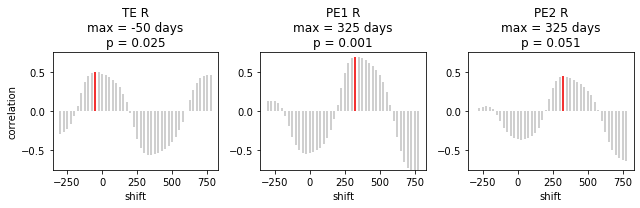

In [216]:
fig, axs = plt.subplots(1,3, figsize=(9,3), tight_layout=True)

# plot as vertical lines
axs[0].vlines(shifts, np.zeros(len(shifts)), te_r, color="silver")

# get argmax and plot that
ix = np.argmax(te_r)
axs[0].vlines(shifts[ix], 0, te_r[ix], color="r")
axs[0].set_ylim(-0.75, 0.75)
axs[0].set_xlabel("shift")
axs[0].set_ylabel("correlation")
axs[0].set_title("TE R\nmax = %d days\np = %.3f" % (int(shifts[ix]), te_p[ix]))

# plot as vertical lines
axs[1].vlines(shifts, np.zeros(len(shifts)), pe1_r, color="silver")

# get argmax and plot that
ix = np.argmax(pe1_r)
axs[1].vlines(shifts[ix], 0, pe1_r[ix], color="r")
axs[1].set_ylim(-0.75, 0.75)
axs[1].set_xlabel("shift")
axs[1].set_title("PE1 R\nmax = %d days\np = %.3f" % (int(shifts[ix]), pe1_p[ix]))

# plot as vertical lines
axs[2].vlines(shifts, np.zeros(len(shifts)), pe2_r, color="silver")

# get argmax and plot that
ix = np.argmax(pe2_r)
axs[2].vlines(shifts[ix], 0, pe2_r[ix], color="r")
axs[2].set_ylim(-0.75, 0.75)
axs[2].set_xlabel("shift")
axs[2].set_title("PE2 R\nmax = %d days\np = %.3f" % (int(shifts[ix]), pe2_p[ix]))

#plt.savefig("correlations.pdf")